In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split, KFold
from sklearn.linear_model import Lasso
import scipy.stats
import time

mpl.style.use("seaborn-darkgrid")
mpl.rcParams["image.cmap"] = "gnuplot2"
mpl.rcParams['figure.figsize'] = [8.0, 6.0]

np.random.seed(1942)

# 1. Linear Regression on Generic Data

## 1.1 The Franke Funtion, with noise

In [28]:
def Franke(x, y):
    term1 = 0.75*np.exp(-(0.25*(9*x-2)**2) - 0.25*((9*y-2)**2))
    term2 = 0.75*np.exp(-((9*x+1)**2)/49.0 - 0.1*(9*y+1))
    term3 = 0.5*np.exp(-(9*x-7)**2/4.0 - 0.25*((9*y-3)**2))
    term4 = -0.2*np.exp(-(9*x-4)**2 - (9*y-7)**2)
    return term1 + term2 + term3 + term4

def FrankeNoise(x, y, sigma=0.1):
    return Franke(x, y) + np.random.normal(0, sigma, np.shape(x))

In [3]:
nr_points_per_dim = 201
nr_datapoints = nr_points_per_dim**2

### 1.1.1 Plotting the Franke Function, with and without noise

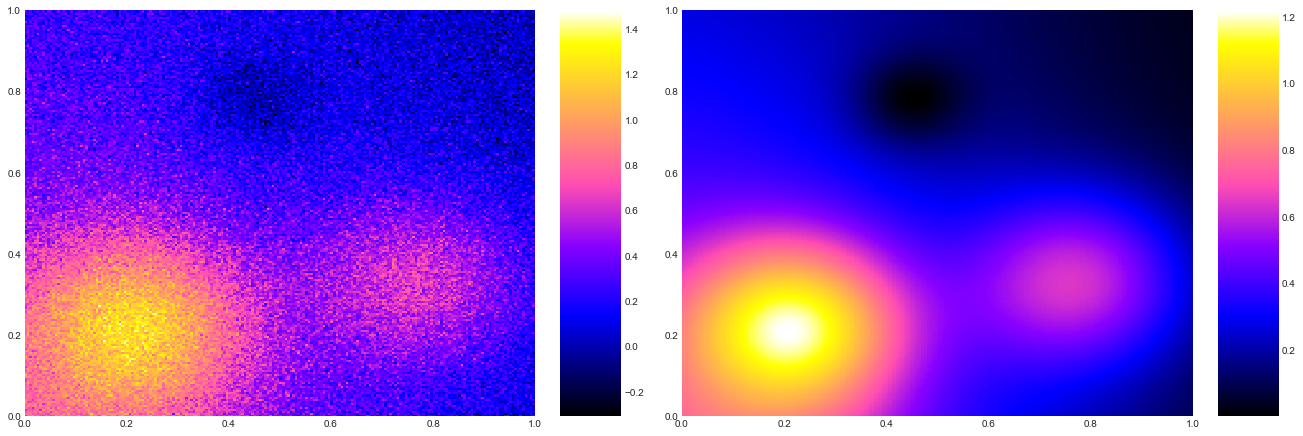

In [29]:
x = np.linspace(0, 1, nr_points_per_dim)
y = np.linspace(0, 1, nr_points_per_dim)
#x = np.random.uniform(0, 1, nr_points_per_dim)
#y = np.random.uniform(0, 1, nr_points_per_dim)
x_, y_ = np.meshgrid(x, y)

x_flat = x_.flatten()
y_flat = y_.flatten()

data = FrankeNoise(x_, y_,sigma=1)
f = data.flatten()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18,6))
plt1 = ax1.pcolormesh(x_, y_, FrankeNoise(x_,y_));
fig.colorbar(plt1, ax=ax1);

plt2 = ax2.pcolormesh(x_, y_, Franke(x_, y_))
fig.colorbar(plt2, ax=ax2);

## 1.2 Setting up the design matrix and model

In [5]:
poly_order = 5

### 1.2.1 The design matrix, X

In [6]:
def make_X(x_flat, y_flat, poly_order):
    nr_terms = ((poly_order + 1)*(poly_order + 2))//2
    X = np.zeros((np.size(x_flat), nr_terms))
    X[:,0] = 1

    i = 0
    for ix in range(poly_order+1):
        for iy in range(poly_order+1):
            if 0 < ix + iy < poly_order+1:
                i += 1
                X[:,i] = x_flat**ix*y_flat**iy
    return X

### 1.2.2 The Model

In [7]:
def Model(beta, x, y, poly_order):
    i = 0
    result = beta[0]
    for ix in range(poly_order+1):
        for iy in range(poly_order+1):
            if 0 < ix + iy < poly_order+1:
                i += 1
                result += beta[i]*x**ix*y**iy
    return result

## 1.3 Predicting model from noisy data with Linear Regression using OLS

In [8]:
X = make_X(x_flat, y_flat, poly_order)
beta = np.linalg.inv(X.T@X)@X.T@f
data_pred = Model(beta, x_, y_, poly_order)

## 1.4 Results

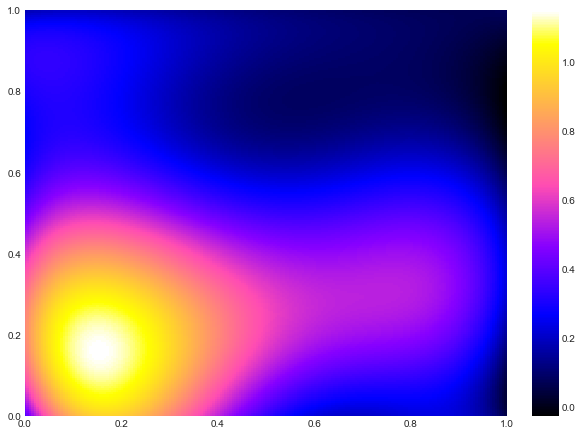

In [9]:
plt.figure(figsize=(8,6))
plt.pcolormesh(x_, y_, data_pred)
plt.colorbar();

## 1.4.1 Score values

In [10]:
print("MSE Score = ", MSE(data, data_pred))
print("RRMSE Score = ", np.sqrt(MSE(data, data_pred))/np.mean(data))
print("MSE Score (vs true model) =", MSE(Franke(x_, y_), data_pred))

MSE Score =  0.012022683506344002
RRMSE Score =  0.2701401309280632
MSE Score (vs true model) = 0.0020445043391576208


In [11]:
print("R2 Score = ", r2_score(data, data_pred))

R2 Score =  0.7535591453610659


## 1.4.2 Analysing the noise

In [12]:
noise_pred = data - data_pred

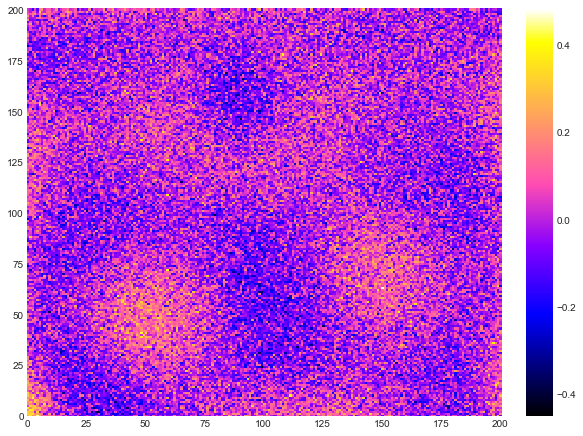

In [13]:
plt.figure(figsize = (8, 6))
plt.pcolormesh(noise_pred)
plt.colorbar();

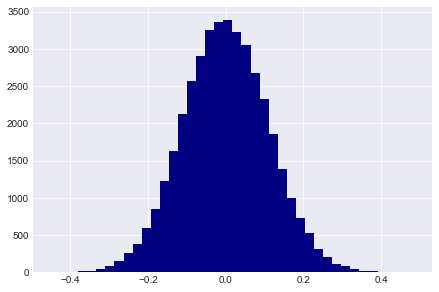

In [14]:
plt.hist(noise_pred.flatten(), bins=40, color="navy");

### 1.4.3 Probability Plot - Confirming normal distribution of noise

0.9999399913762357

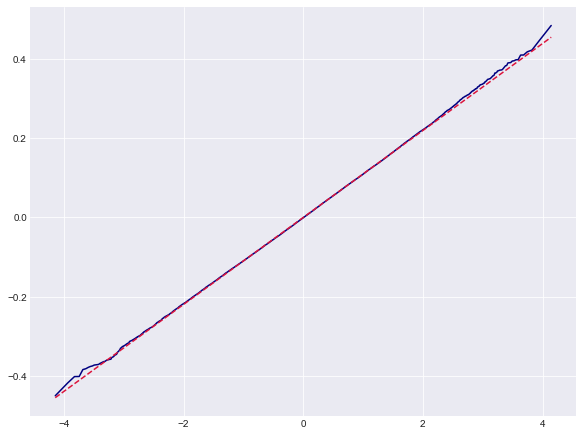

In [15]:
(x, y), (slope, intercept, r) = scipy.stats.probplot(noise_pred.flatten());

plt.figure(figsize = (8,6))
plt.plot(x, y, color="navy");
plt.plot(x, intercept + x*slope, ls="--", c="crimson")
r

## 1.5 Round 2 - Running the model for different polynomial degrees

0.0014989376068115234
0.0032739639282226562
0.01188516616821289
0.02339625358581543
0.03647279739379883
0.05758810043334961
0.08657598495483398
0.1031198501586914
0.13925933837890625
0.17255783081054688
0.2243649959564209
0.28061890602111816
0.3532700538635254
0.42939186096191406
0.46863698959350586
0.46611475944519043


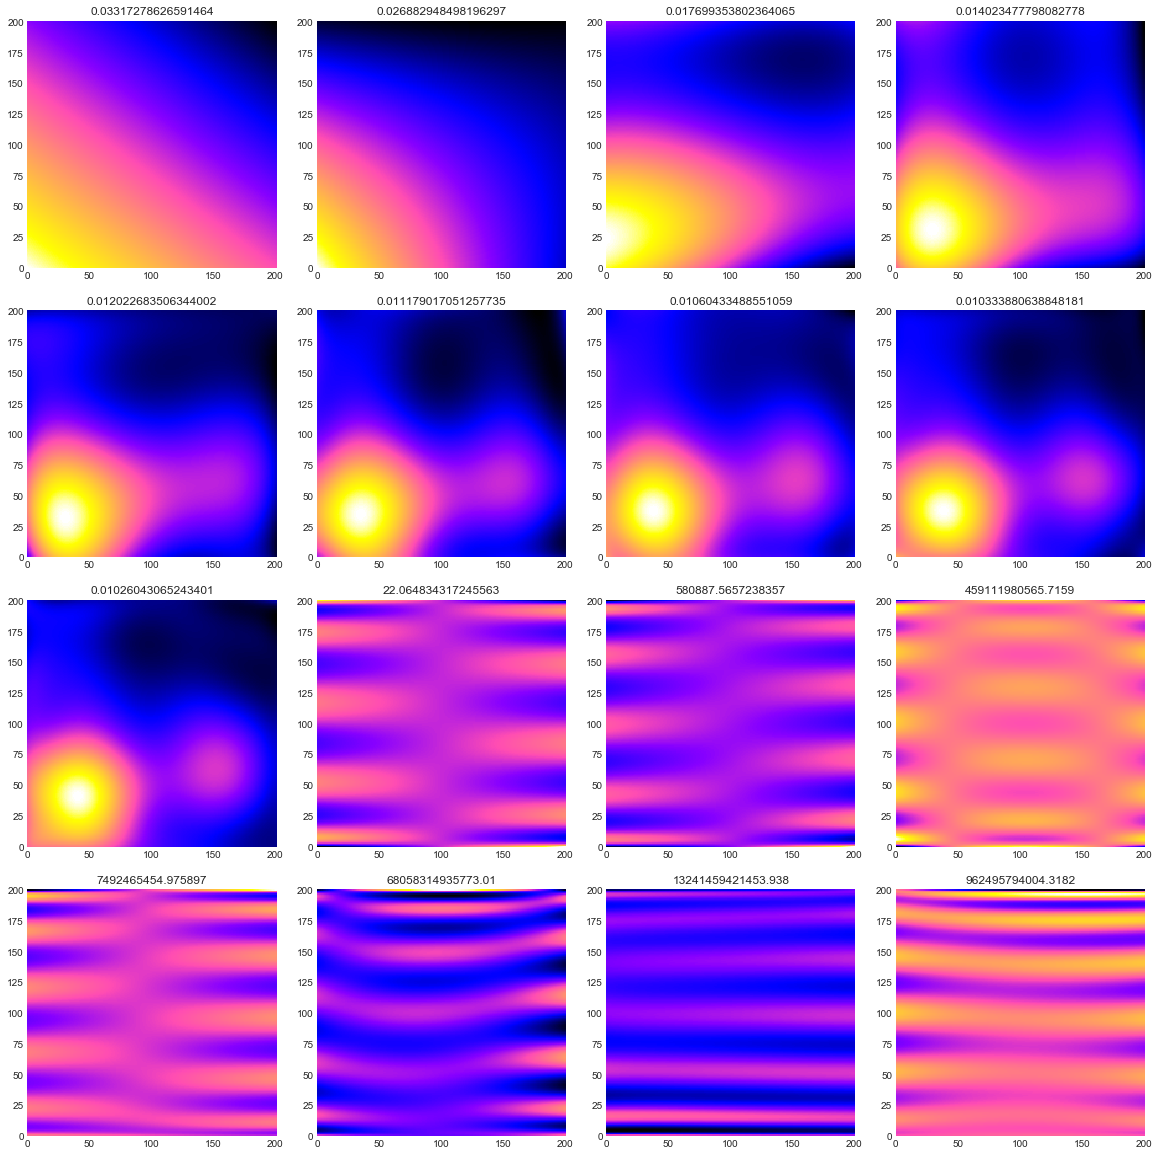

In [16]:
err_list = []
err_list_truemodel = []
nr_poly_orders = 16
poly_orders = np.arange(1, nr_poly_orders + 1)

fig, ax = plt.subplots(nr_poly_orders//4, 4, figsize=(16, 4*nr_poly_orders//4))

for i, poly_order in enumerate(poly_orders):
    t0 = time.time()
    X = make_X(x_flat, y_flat, poly_order)
    beta = np.linalg.inv(X.T@X)@X.T@f
    #print(i, beta)
    data_pred = Model(beta, x_, y_, poly_order)
    print(time.time() - t0)
    #plt.figure(figsize=(8,8))
    ax[i//4, i%4].pcolormesh(data_pred)
    ax[i//4, i%4].set_title(MSE(data_pred, data))
    err_list.append(np.sum(np.abs(data - data_pred)))
    err_list_truemodel.append(np.sum(np.abs(Franke(x_, y_) - data_pred)))    

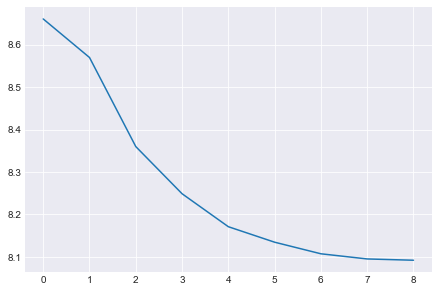

In [17]:
plt.plot(np.log(err_list[:9]));

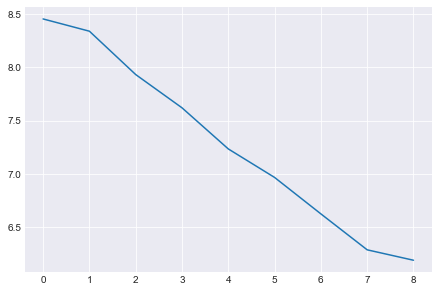

In [18]:
plt.plot(np.log(err_list_truemodel[:9]));

# 2 Ridge Regression

0.005220890045166016
0.0041501522064208984
0.008087158203125
0.02100086212158203
0.03983783721923828
0.057315826416015625
0.09358096122741699
0.10114097595214844


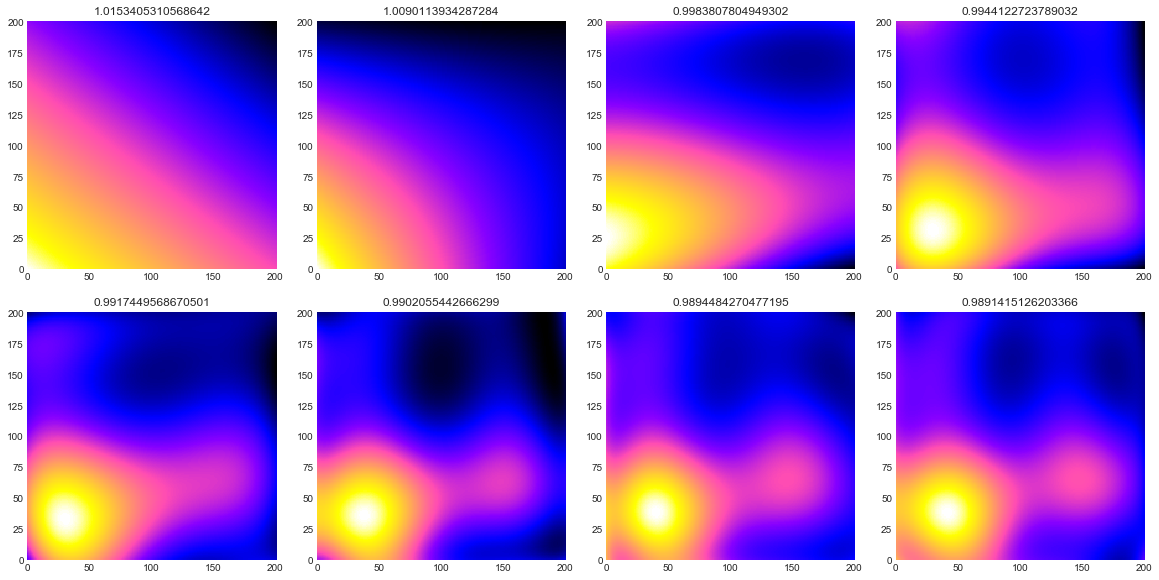

In [32]:
lamda = 1e-8

err_list = []
err_list_truemodel = []
nr_poly_orders = 4*2
poly_orders = np.arange(1, nr_poly_orders + 1)

fig, ax = plt.subplots(nr_poly_orders//4, 4, figsize=(16, 4*nr_poly_orders//4))

for i, poly_order in enumerate(poly_orders):
    t0 = time.time()
    X = make_X(x_flat, y_flat, poly_order)
    beta = np.linalg.inv(X.T@X + np.identity(X.shape[1])*lamda)@X.T@f
    #print(i, beta)
    data_pred = Model(beta, x_, y_, poly_order)
    print(time.time() - t0)
    #plt.figure(figsize=(8,8))
    ax[i//4, i%4].pcolormesh(data_pred)
    ax[i//4, i%4].set_title(MSE(data_pred, data))
    err_list.append(np.sum(np.abs(data - data_pred)))
    err_list_truemodel.append(np.sum(np.abs(Franke(x_, y_) - data_pred)))

In [ ]:
plt.plot(np.log(err_list));

In [ ]:
plt.plot(np.log(err_list_truemodel));

# Lasso regression

i 0
beta shape (3,)
0.006464719772338867


IndexError: too many indices for array

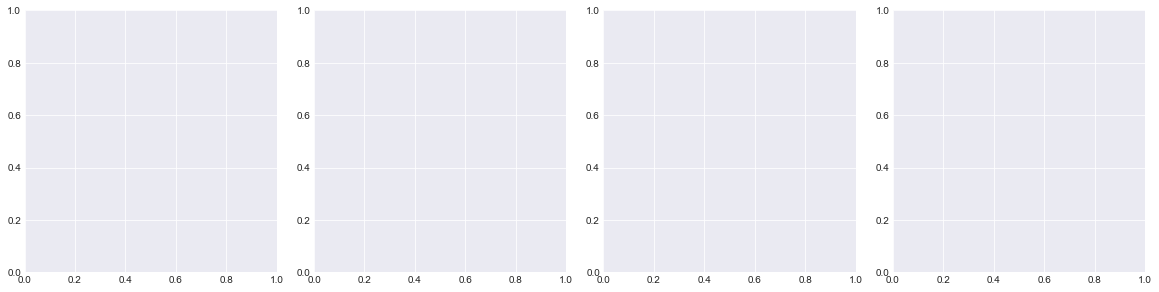

In [33]:
lamda = 1e-5

err_list = []
err_list_truemodel = []
lower_poly_order = 1
nr_poly_orders = 4
poly_orders = np.arange(lower_poly_order, lower_poly_order+nr_poly_orders)

fig, ax = plt.subplots(nr_poly_orders//4, 4, figsize=(16, 4*nr_poly_orders//4))

for i, poly_order in enumerate(poly_orders):
    print('i',i)
    t0 = time.time()
    X = make_X(x_flat, y_flat, poly_order)
    
    _lasso = Lasso(alpha=lamda,max_iter=1e3,tol=0.001)
    clf = _lasso.fit(X,f)
    data_pred = Model(clf.coef_,x_,y_,poly_order)
    print('beta shape',clf.coef_.shape)
 #   data_pred = X*clf.coef_
#    print(data_pred.shape)

    print(time.time() - t0)

    ax[i//4, i%4].pcolormesh(data_pred)
    ax[i//4, i%4].set_title(MSE(data_pred, data))
    
    err_list.append(np.sum(np.abs(data - data_pred)))
    err_list_truemodel.append(np.sum(np.abs(Franke(x_, y_) - data_pred)))

# 3. Train-test split

In [ ]:
poly_order = 5

input_ = np.zeros((nr_datapoints, 2))
input_[:,0] = x_flat
input_[:,1] = y_flat

In [ ]:
input_train, input_test, output_train, output_test = train_test_split(input_, f, test_size = 0.3)

In [ ]:
X = make_X(input_train[:,0], input_train[:,1], poly_order)
beta = np.linalg.inv(X.T@X)@X.T@output_train

output_test_pred = Model(beta, input_test[:,0], input_test[:,1], poly_order)

In [ ]:
MSE(output_test, output_test_pred)

# 4. K-fold validation

In [ ]:
#class KFold_iterator
#    def __init__(self, input_dim, nr_splits=5):
    

#def KFold_indexes(input_dim, nr_splits=5):
#    indexes = np.arange(input_dim)
#    np.random.shuffle(indexes)
#    cut_indexes = np.array_split(indexes, nr_splits)
#    print(cut_indexes)
#KFold_indexes(10)

In [ ]:
def K_fold_validation(input_, output, K=5):
    output_pred = np.zeros(nr_datapoints)
    kf = KFold(n_splits = K, shuffle=True)
    for train_index, test_index in kf.split(input_):
        input_train, input_test = input_[train_index], input_[test_index]
        output_train, output_test = output[train_index], output[test_index]
        X = make_X(input_train[:,0], input_train[:,1], poly_order)
        beta = np.linalg.inv(X.T@X)@X.T@output_train

        output_test_pred = Model(beta, input_test[:,0], input_test[:,1], poly_order)
        output_pred[test_index] = output_test_pred
    return output_pred

In [ ]:
output_pred = K_fold_validation(input_, f)

In [ ]:
MSE(output_pred, f)